# Time series - Li2Co3 zeroes calculations and statistics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from tabulate import tabulate
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
from google.colab import files
from sklearn.metrics import mean_squared_error

# P1. Data Preprocess

In [ ]:
# Data from 2017-05-10 to 2024-04-19
li2co3 = pd.read_csv(r'/content/Lithium Carbonate 99%Min China Spot Historical Data (5).csv')
li2co3['Date'] = pd.to_datetime(li2co3['Date'])
# The date order need to be inverted (from early to late)
li2co3 = li2co3.sort_values('Date')
li2co3.set_index('Date', inplace=True)
li2co3 = pd.DataFrame(li2co3["Price"])


li2co3['Price'] = (li2co3['Price'].str.replace(",","").astype(float))
na_count = li2co3['Price'].isna().sum()
print("Number of missing values:", na_count)
if na_count > 0:
  li2co3 = li2co3.dropna(subset=['Price'])

# daily log returns
li2co3['log_ret'] = np.log(li2co3['Price']).diff()
li2co3 = li2co3.dropna(subset=['log_ret'])

Number of missing values: 0


In [ ]:
li2co3.head(10)

,Price,log_ret
Date,,
2017-05-11,123000.0,0.000000
2017-05-12,123000.0,0.000000
2017-05-15,123000.0,0.000000
2017-05-16,123000.0,0.000000
2017-05-17,123000.0,0.000000
2017-05-18,123000.0,0.000000
2017-05-19,124000.0,0.008097
2017-05-22,124000.0,0.000000
2017-05-23,124000.0,0.000000


In [ ]:
li2co3.tail(10)

,Price,log_ret
Date,,
2024-04-08,109500.0,0.027780
2024-04-09,109500.0,0.000000
2024-04-10,110500.0,0.009091
2024-04-11,109500.0,-0.009091
2024-04-12,109500.0,0.000000
2024-04-15,109500.0,0.000000
2024-04-16,109500.0,0.000000
2024-04-17,109500.0,0.000000
2024-04-18,109500.0,0.000000


# P2. Weekly log return series and zero count series

In [ ]:
Fridays = pd.DataFrame()
Thursdays = pd.DataFrame()
Wednesdays = pd.DataFrame()
Tuesdays = pd.DataFrame()
Mondays = pd.DataFrame()

In [ ]:
def weekly_returns(data, chosen_day):
    # chosen_day = ['W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-FRI']
    weekly_log_return = data.groupby(pd.Grouper(freq=chosen_day))['log_ret'].sum()
    weekly_log_return = weekly_log_return.dropna()
    return weekly_log_return

In [ ]:
def count_zero(df, chosen_day):
    # chosen_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    # Create a zero dummy series: 1 if 'log_ret' is zero, 0 otherwise
    data = df.copy()
    data['zero_dummy'] = (data['log_ret'] == 0).astype(int)
    # Compute the sum of past 22 days and past 5 days for zero_dummy
    data['zero_count_22'] = data['zero_dummy'].rolling(window=22).sum()
    data['zero_count_5'] = data['zero_dummy'].rolling(window=5).sum()
    data = data.dropna()
    # Extract chosen day
    data['day_of_week'] = data.index.day_name()
    chosendays_data = data[data['day_of_week'] == chosen_day]

    # Select only the zero count columns and the index for Fridays
    chosendays_data = chosendays_data[['zero_count_22', 'zero_count_5']]
    chosendays_data['zero_count_22'] = chosendays_data['zero_count_22'].astype(int)
    chosendays_data['zero_count_5'] = chosendays_data['zero_count_5'].astype(int)
    return chosendays_data

In [ ]:
# Friday to Friday
Fridays['Log_Return'] = weekly_returns(li2co3, 'W-FRI')
Fridays['Zero_Count_22'] = count_zero(li2co3, 'Friday')['zero_count_22']
Fridays['Zero_Count_5'] = count_zero(li2co3, 'Friday')['zero_count_5']
Fridays = Fridays.dropna()

# Thursday to Thursday
Thursdays['Log_Return'] = weekly_returns(li2co3, 'W-THU')
Thursdays['Zero_Count_22'] = count_zero(li2co3, 'Thursday')['zero_count_22']
Thursdays['Zero_Count_5'] = count_zero(li2co3, 'Thursday')['zero_count_5']
Thursdays = Thursdays.dropna()

# Wednesday to Wednesday
Wednesdays['Log_Return'] = weekly_returns(li2co3, 'W-WED')
Wednesdays['Zero_Count_22'] = count_zero(li2co3, 'Wednesday')['zero_count_22']
Wednesdays['Zero_Count_5'] = count_zero(li2co3, 'Wednesday')['zero_count_5']
Wednesdays = Wednesdays.dropna()

# Tuesday to Tuesday
Tuesdays['Log_Return'] = weekly_returns(li2co3, 'W-TUE')
Tuesdays['Zero_Count_22'] = count_zero(li2co3, 'Tuesday')['zero_count_22']
Tuesdays['Zero_Count_5'] = count_zero(li2co3, 'Tuesday')['zero_count_5']
Tuesdays = Tuesdays.dropna()

# Monday to Monday
Mondays['Log_Return'] = weekly_returns(li2co3, 'W-MON')
Mondays['Zero_Count_22'] = count_zero(li2co3, 'Monday')['zero_count_22']
Mondays['Zero_Count_5'] = count_zero(li2co3, 'Monday')['zero_count_5']
Mondays = Mondays.dropna()

In [ ]:
print("Friday to Firday")
print(Fridays.tail(10))
print("Thursday to Thursday")
print(Thursdays.tail(10))
print("Wednesday to Wednesday")
print(Wednesdays.tail(10))
print("Tuesday to Tuesday")
print(Tuesdays.tail(10))
print("Monday to Monday")
print(Mondays.tail(10))

Friday to Firday
            Log_Return  Zero_Count_22  Zero_Count_5
Date                                               
2024-01-26    0.000000           22.0           5.0
2024-02-02    0.000000           22.0           5.0
2024-02-23   -0.005666           20.0           4.0
2024-03-01    0.092206           16.0           1.0
2024-03-08    0.050516           14.0           3.0
2024-03-15    0.038652           10.0           0.0
2024-03-22    0.028039            8.0           2.0
2024-03-29   -0.037563            7.0           2.0
2024-04-12    0.027780            7.0           2.0
2024-04-19    0.000000           12.0           5.0
Thursday to Thursday
            Log_Return  Zero_Count_22  Zero_Count_5
Date                                               
2024-01-25    0.000000           22.0           5.0
2024-02-01    0.000000           22.0           5.0
2024-02-22   -0.005666           20.0           4.0
2024-02-29    0.071263           17.0           2.0
2024-03-07    0.071459    

# P3. Summary statistics

In [ ]:
summary_statistics_Fridays = Fridays.describe().loc[['mean', 'min', 'max', 'std']]
summary_statistics_Thursdays = Thursdays.describe().loc[['mean', 'min', 'max', 'std']]
summary_statistics_Wednesdays = Wednesdays.describe().loc[['mean', 'min', 'max', 'std']]
summary_statistics_Tuesdays = Tuesdays.describe().loc[['mean', 'min', 'max', 'std']]
summary_statistics_Mondays = Mondays.describe().loc[['mean', 'min', 'max', 'std']]

print("Friday to Firday")
print(summary_statistics_Fridays)
print("Thursday to Thursday")
print(summary_statistics_Thursdays)
print("Wednesday to Wednesday")
print(summary_statistics_Wednesdays)
print("Tuesday to Tuesday")
print(summary_statistics_Tuesdays)
print("Monday to Monday")
print(summary_statistics_Mondays)

Friday to Firday
      Log_Return  Zero_Count_22  Zero_Count_5
mean   -0.000397      15.089783      3.421053
min    -0.152469       0.000000      0.000000
max     0.267022      22.000000      5.000000
std     0.044616       5.608998      1.584804
Thursday to Thursday
      Log_Return  Zero_Count_22  Zero_Count_5
mean   -0.000692      15.096386      3.418675
min    -0.172141       0.000000      0.000000
max     0.204501      22.000000      5.000000
std     0.044082       5.556335      1.576646
Wednesday to Wednesday
      Log_Return  Zero_Count_22  Zero_Count_5
mean   -0.000154      15.036145      3.418675
min    -0.190575       0.000000      0.000000
max     0.252326      22.000000      5.000000
std     0.044743       5.529806      1.533911
Tuesday to Tuesday
      Log_Return  Zero_Count_22  Zero_Count_5
mean   -0.000803      15.026946      3.410180
min    -0.163827       0.000000      0.000000
max     0.298955      22.000000      5.000000
std     0.045178       5.532529      1.552684


# P4. Autocorrelogram and partial autocorrelogram for daily return

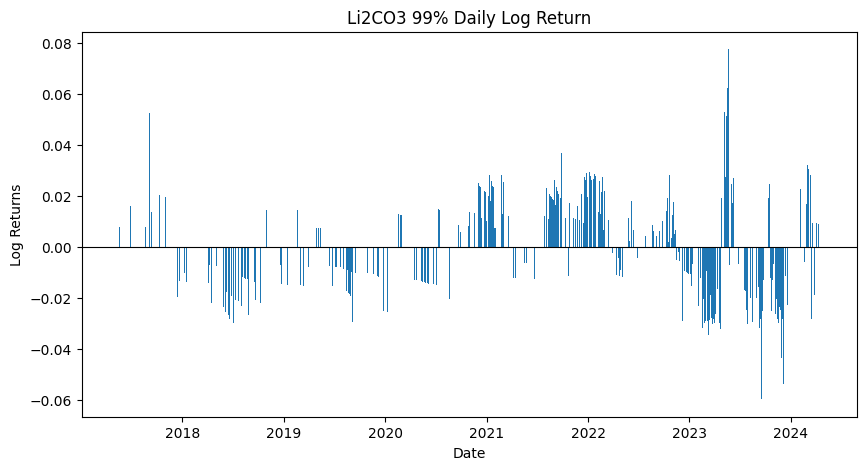

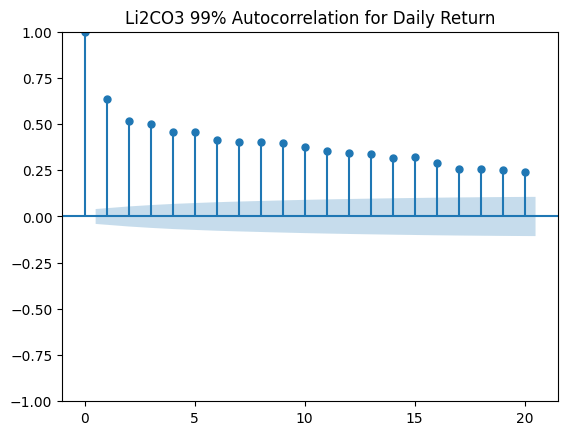

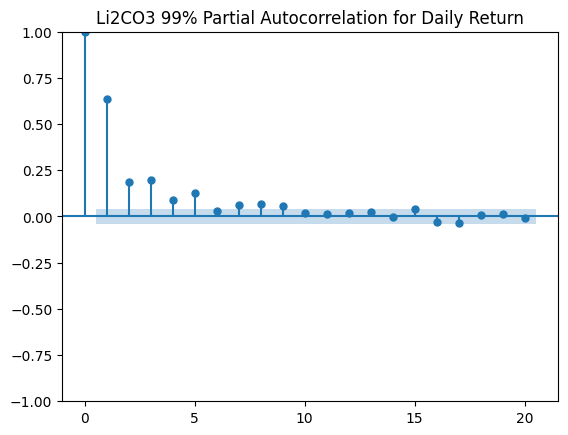

In [ ]:
# Daily return
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.bar(li2co3.index, li2co3['log_ret'], width=2.5)
plt.axhline(0, linewidth=0.8, color='k')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Li2CO3 99% Daily Log Return')
plt.show()

# Plot autocorrelation and partial autocorrelation
acf = plot_acf(li2co3['log_ret'], lags=20, alpha=0.1, title='Li2CO3 99% Autocorrelation for Daily Return')
pacf = plot_pacf(li2co3['log_ret'], lags=20, alpha=0.1, method='ywm', title='Li2CO3 99% Partial Autocorrelation for Daily Return')

# P5. Autocorrelogram and partial autocorrelogram for weekly return

In [ ]:
def plot_returns_acf_pacf(df, df_name):
    """
    Plots the log returns, autocorrelation, and partial autocorrelation for a given DataFrame.

    Parameters:
    - df: The DataFrame containing the log returns data.
    - df_name: Name of the DataFrame to use in plot titles to indicate the data source.
    """
    data = df.copy()

    # Plotting the log returns
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.bar(data.index, data['Log_Return'], width=2.5)
    plt.axhline(0, linewidth=0.8, color='k')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.title(f'Li2CO3 99% {df_name} Weekly Log Return')
    plt.show()

    # Plotting the autocorrelation
    fig_acf = plot_acf(data['Log_Return'], lags=20, alpha=0.1, title=f'Autocorrelation for {df_name} Weekly Return')

    # Plotting the partial autocorrelation
    fig_pacf = plot_pacf(data['Log_Return'], lags=20, alpha=0.1, method='ywm', title=f'Partial Autocorrelation for {df_name} Weekly Return')
    plt.show()

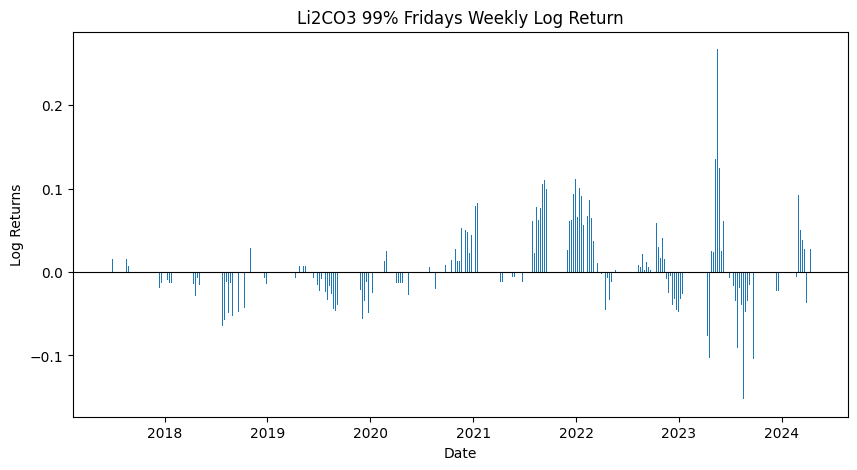

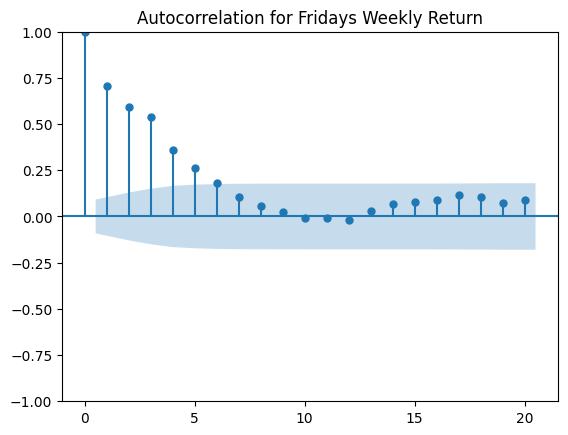

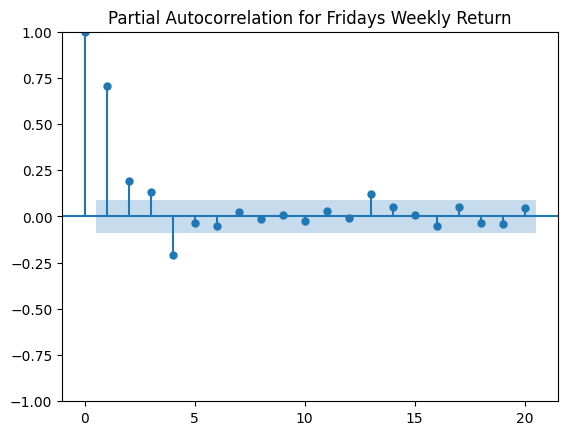

In [ ]:
# Fridays
plot_returns_acf_pacf(Fridays, 'Fridays')

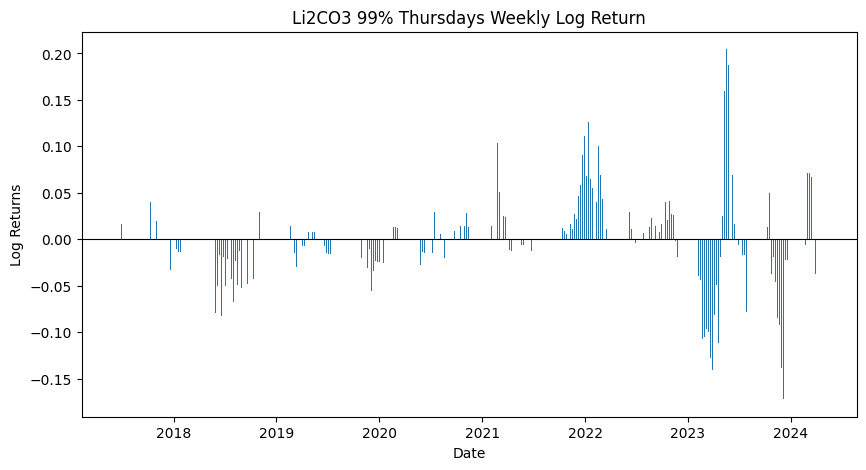

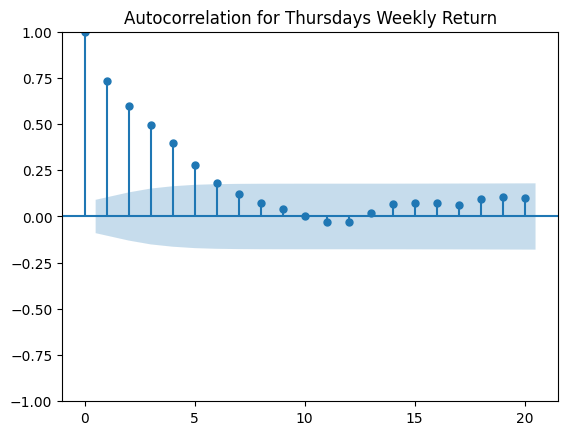

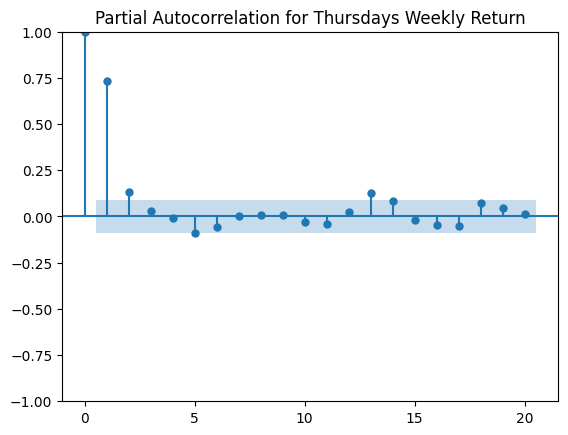

In [ ]:
# Thursdays
plot_returns_acf_pacf(Thursdays, 'Thursdays')

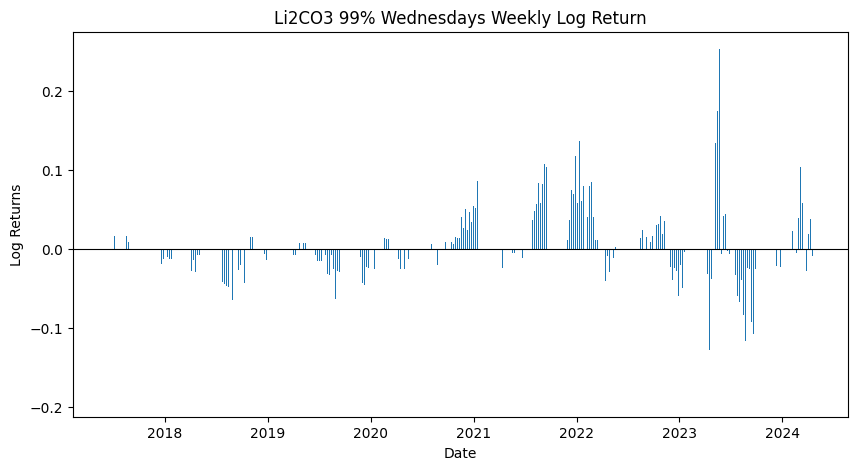

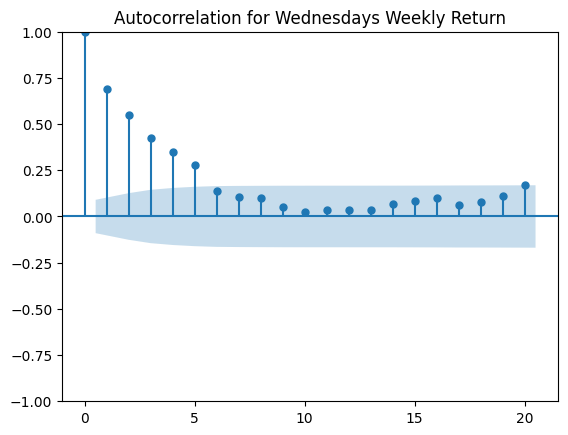

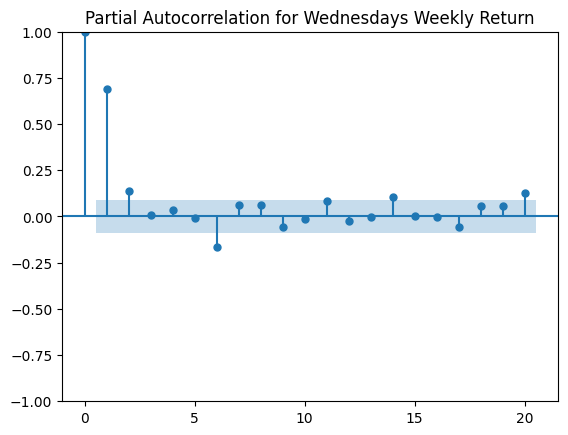

In [ ]:
# Wednesdays
plot_returns_acf_pacf(Wednesdays, 'Wednesdays')

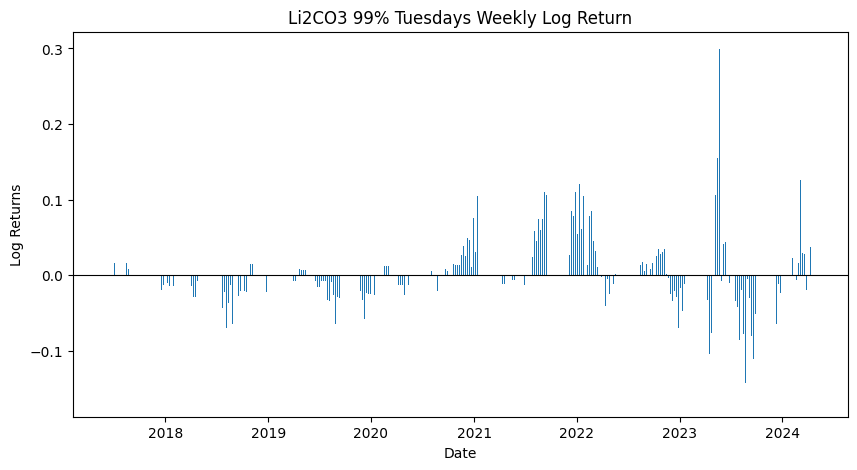

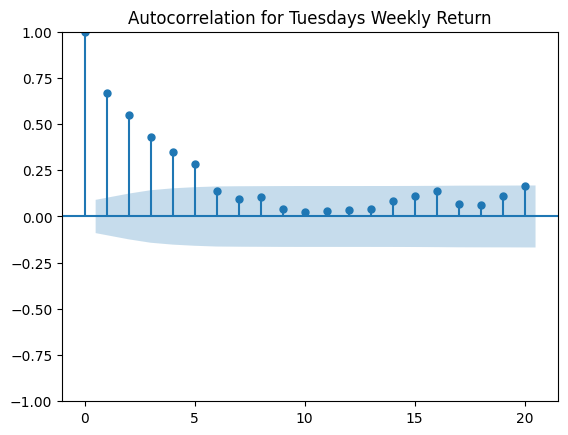

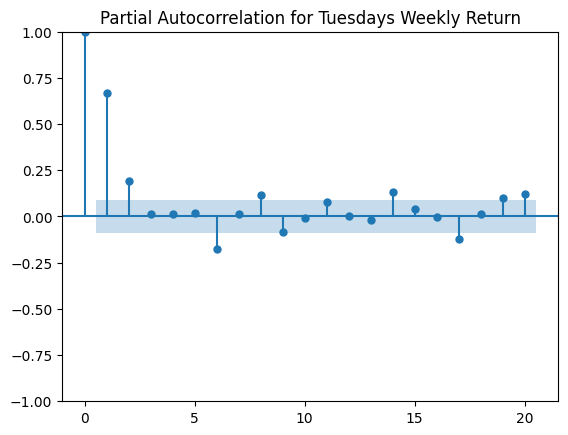

In [ ]:
# Tuesdays
plot_returns_acf_pacf(Tuesdays, 'Tuesdays')

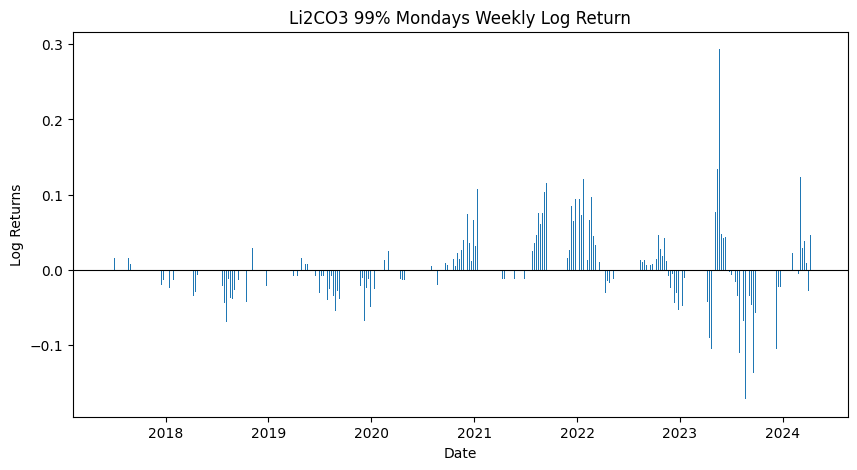

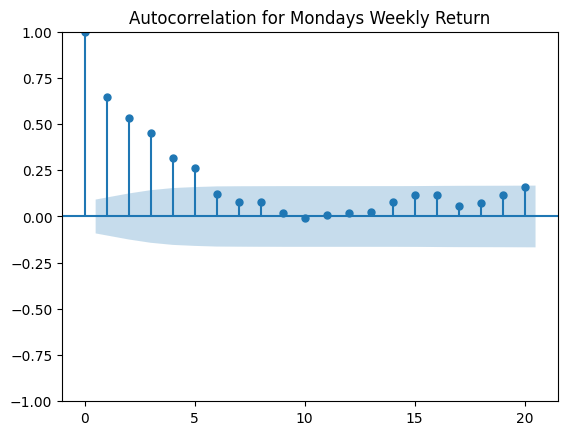

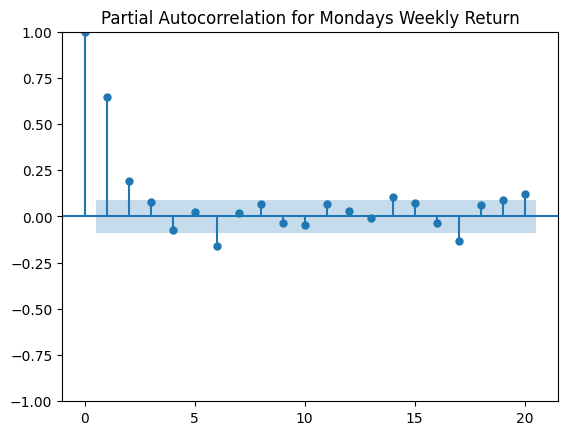

In [ ]:
# Mondays
plot_returns_acf_pacf(Mondays, 'Mondays')

maxlags = 4 for Fridays

maxlags = 2 for others

# P6. Two AR(2) models for daily return

In [ ]:
def estimate_ar2_model(df, lags):
    """
    Estimate a basic AR(2) model for returns.

    Parameters:
    - df: DataFrame containing the log returns series under 'log_ret'.
    - lags: Number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model.
    """

    data = df.copy()
    data['log_ret_lag1'] = data['log_ret'].shift(1)
    data['log_ret_lag2'] = data['log_ret'].shift(2)

    data.dropna(inplace=True)

    # Define the variables and add a constant term for the intercept (alpha)
    X = data[['log_ret_lag1', 'log_ret_lag2']]
    X = sm.add_constant(X)  # Adds a constant column to input data set
    Y = data['log_ret']

    # Fit the AR(2) model
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model

In [ ]:
# lags=5 acording to the daily pacf
daily_return_ar2_model = estimate_ar2_model(li2co3, lags=5)

In [ ]:
print(daily_return_ar2_model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ret   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     188.0
Date:                Sun, 12 May 2024   Prob (F-statistic):           2.62e-74
Time:                        20:46:31   Log-Likelihood:                 5540.0
No. Observations:                1662   AIC:                        -1.107e+04
Df Residuals:                    1659   BIC:                        -1.106e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.075e-05      0.000     -0.104   

In [ ]:
def estimate_ar2_model_with_zero_dummy(df, lags):
    """
    Estimate an AR(2) model for log returns with modifications to account for zero dummies.

    Parameters:
    - df: DataFrame containing the log returns 'log_ret'.
    - lags: Number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model.
    """

    data = df.copy()
    data['zero_dummy'] = (data['log_ret'] == 0).astype(int)

    # Generate lagged return series
    data['log_ret_lag1'] = data['log_ret'].shift(1)
    data['log_ret_lag2'] = data['log_ret'].shift(2)

    # Generate interaction terms
    data['log_ret_lag1_zero'] = data['log_ret_lag1'] * data['zero_dummy']
    data['log_ret_lag2_zero'] = data['log_ret_lag2'] * data['zero_dummy']

    data.dropna(inplace=True)

    # Define the new model with additional interaction terms
    X = data[['zero_dummy', 'log_ret_lag1', 'log_ret_lag2', 'log_ret_lag1_zero', 'log_ret_lag2_zero']]
    X = sm.add_constant(X)
    Y = data['log_ret']

    # Fit the AR(2) model
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model

In [ ]:
# lags=5 acording to the daily pacf
daily_return_ar2_model_with_zero_dummy = estimate_ar2_model_with_zero_dummy(li2co3, lags = 5)

In [ ]:
print(daily_return_ar2_model_with_zero_dummy.summary())

                            OLS Regression Results                            
Dep. Variable:                log_ret   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     442.3
Date:                Sun, 12 May 2024   Prob (F-statistic):          5.35e-211
Time:                        20:46:35   Log-Likelihood:                 5856.5
No. Observations:                1662   AIC:                        -1.170e+04
Df Residuals:                    1656   BIC:                        -1.167e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0010      0.00

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '


# P7. Four AR(2) models for returns with zero count series (use Fridays as example)

## Model1: Standard AR(2) model

In [ ]:
def estimate_ar2_model(df, lags):
    """
    Estimate a basic AR(2) model for returns.

    Parameters:
    - df: DataFrame containing the log returns series under 'Log_Return'.
    - lags: Number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model.
    """

    data = df.copy()
    data['log_ret_lag1'] = data['Log_Return'].shift(1)
    data['log_ret_lag2'] = data['Log_Return'].shift(2)

    data.dropna(inplace=True)

    # Define the variables and add a constant term for the intercept (alpha)
    X = data[['log_ret_lag1', 'log_ret_lag2']]
    X = sm.add_constant(X)  # Adds a constant column to input data set
    Y = data['Log_Return']

    # Fit the AR(2) model
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model

In [ ]:
# lags=4 acording to the weekly pacf
weekly_return_ar2_model = estimate_ar2_model(Fridays, lags=4)

print(weekly_return_ar2_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     84.51
Date:                Sun, 12 May 2024   Prob (F-statistic):           3.69e-30
Time:                        20:46:38   Log-Likelihood:                 658.66
No. Observations:                 321   AIC:                            -1311.
Df Residuals:                     318   BIC:                            -1300.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.831e-05      0.002     -0.044   

## Model2: AR(2) model using interaction with the weekly zero count series

In [ ]:
def estimate_ar2_model_with_weekly_zero(df, lags):
    """
    Estimate an AR(2) model for weekly log returns, incorporating
    weekly zero count series as interaction effect,
    and allowing for specification of lags for HAC standard errors.

    Parameters:
    - df: DataFrame containing the weekly log returns under 'Log_Return',
        and the weekly zero count series 'Zero_Count_5'.
    - lags: Maximum number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model with HAC standard errors.
    """

    data = df.copy()
    # Generate lagged return series
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag2'] = data['Log_Return'].shift(2)

    # Generate interaction terms for lagged returns and 'Zero_Count_5'
    data['Log_Return_Lag1_Zero5'] = data['Log_Return_Lag1'] * data['Zero_Count_5']
    data['Log_Return_Lag2_Zero5'] = data['Log_Return_Lag2'] * data['Zero_Count_5']

    # Drop any rows with NaN values that were created by lagging
    data.dropna(inplace=True)

    # Define the model with additional interaction terms
    X = data[['Zero_Count_5', 'Log_Return_Lag1', 'Log_Return_Lag2',
              'Log_Return_Lag1_Zero5', 'Log_Return_Lag2_Zero5']]
    X = sm.add_constant(X)
    Y = data['Log_Return']

    # Fit the model with HAC standard errors
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model

In [ ]:
# lags=4 acording to the weekly pacf
ar2_model_with_weekly_zero = estimate_ar2_model_with_weekly_zero(Fridays, lags=4)

print(ar2_model_with_weekly_zero.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     61.77
Date:                Sun, 12 May 2024   Prob (F-statistic):           9.64e-45
Time:                        20:46:41   Log-Likelihood:                 713.29
No. Observations:                 321   AIC:                            -1415.
Df Residuals:                     315   BIC:                            -1392.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

## Model3: AR(2) model using interaction with the monthly zero count series

In [ ]:
def estimate_ar2_model_with_monthly_zero(df, lags):
    """
    Estimate an AR(2) model for weekly log returns, incorporating
    monthly zero count series as interaction effect,
    and allowing for specification of lags for HAC standard errors.

    Parameters:
    - df: DataFrame containing the weekly log returns under 'Log_Return',
        and the monthly zero count series 'Zero_Count_22'.
    - lags: Maximum number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model with HAC standard errors.
    """

    data = df.copy()
    # Generate lagged return series
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag2'] = data['Log_Return'].shift(2)

    # Generate interaction terms for lagged returns and 'Zero_Count_22'
    data['Log_Return_Lag1_Zero22'] = data['Log_Return_Lag1'] * data['Zero_Count_22']
    data['Log_Return_Lag2_Zero22'] = data['Log_Return_Lag2'] * data['Zero_Count_22']

    # Drop any rows with NaN values that were created by lagging
    data.dropna(inplace=True)

    # Define the model with additional interaction terms
    X = data[['Zero_Count_22', 'Log_Return_Lag1', 'Log_Return_Lag2',
              'Log_Return_Lag1_Zero22', 'Log_Return_Lag2_Zero22']]
    X = sm.add_constant(X)
    Y = data['Log_Return']

    # Fit the model with HAC standard errors
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model

In [ ]:
# lags=4 acording to the weekly pacf
ar2_model_with_monthly_zero = estimate_ar2_model_with_monthly_zero(Fridays, lags=4)

print(ar2_model_with_monthly_zero.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     43.84
Date:                Sun, 12 May 2024   Prob (F-statistic):           2.99e-34
Time:                        20:46:45   Log-Likelihood:                 666.79
No. Observations:                 321   AIC:                            -1322.
Df Residuals:                     315   BIC:                            -1299.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

 ## Model4: AR(2) model **separately** using interactions with the short-term illiquidity and long-term illiquidity variable

In [ ]:
def estimate_ar2_model_separate_illiquidity(df, lags):
    """
    Estimate a complex AR(2) model for log returns, incorporating
    separate interactions with two types of zero counts.
    The formula incorporates separate interactions for different lags
    with different term-length zero count measures.

    Parameters:
    - df: DataFrame containing the log returns under 'Log_Return',
        two zero count series 'Zero_Count_5' and 'Zero_Count_22'.
    - lags: Maximum number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model with HAC standard errors.
    """

    data = df.copy()
    # Generate lagged return series
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag2'] = data['Log_Return'].shift(2)

    # Generate separate interaction terms for lagged returns and zero counts
    data['Log_Return_Lag1_Zero5'] = data['Log_Return_Lag1'] * data['Zero_Count_5']
    data['Log_Return_Lag2_Zero22'] = data['Log_Return_Lag2'] * data['Zero_Count_22']

    # Drop any rows with NaN values that were created by lagging
    data.dropna(inplace=True)

    # Define the model with additional interaction terms
    X = data[['Zero_Count_5', 'Zero_Count_22', 'Log_Return_Lag1', 'Log_Return_Lag2',
              'Log_Return_Lag1_Zero5', 'Log_Return_Lag2_Zero22']]
    X = sm.add_constant(X)
    Y = data['Log_Return']

    # Fit the model with HAC standard errors
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})

    return model

In [ ]:
# lags=4 acording to the weekly pacf
ar2_model_with_separate_illiquidity = estimate_ar2_model_separate_illiquidity(Fridays, lags=4)

print(ar2_model_with_separate_illiquidity.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     89.29
Date:                Sun, 12 May 2024   Prob (F-statistic):           6.64e-65
Time:                        20:46:48   Log-Likelihood:                 717.72
No. Observations:                 321   AIC:                            -1421.
Df Residuals:                     314   BIC:                            -1395.
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

## Comparsion among last three models

In [ ]:
model1_results = ar2_model_with_weekly_zero
model2_results = ar2_model_with_monthly_zero
model3_results = ar2_model_with_separate_illiquidity

# Create a DataFrame to summarize the fit statistics
summary_stats = pd.DataFrame({
    'Model': ['Model with Weekly Zero', 'Model with Monthly Zero', 'Model with Separate Illiquidity'],
    'R-squared': [model1_results.rsquared, model2_results.rsquared, model3_results.rsquared],
    'Adj. R-squared': [model1_results.rsquared_adj, model2_results.rsquared_adj, model3_results.rsquared_adj],
    'AIC': [model1_results.aic, model2_results.aic, model3_results.aic],
    'BIC': [model1_results.bic, model2_results.bic, model3_results.bic],
    'F-statistic': [model1_results.fvalue, model2_results.fvalue, model3_results.fvalue]
})

# Print the summary statistics using tabulate
print(tabulate(summary_stats, headers='keys', tablefmt='pretty', showindex=False))

+---------------------------------+--------------------+--------------------+---------------------+---------------------+--------------------+
|              Model              |     R-squared      |   Adj. R-squared   |         AIC         |         BIC         |    F-statistic     |
+---------------------------------+--------------------+--------------------+---------------------+---------------------+--------------------+
|     Model with Weekly Zero      | 0.6555624644924585 | 0.6500952020240849 | -1414.5814877806774 | -1391.9528410418973 | 61.767219648707986 |
|     Model with Monthly Zero     | 0.5398221716814222 | 0.5325177617081115 | -1321.587709665845  | -1298.959062927065  | 43.83645709472929  |
| Model with Separate Illiquidity | 0.6649370501762542 | 0.6585345734280297 | -1421.4392679155076 | -1395.0391800535974 | 89.28868785518402  |
+---------------------------------+--------------------+--------------------+---------------------+---------------------+--------------------+

## Interpretation

**R-squared** & **Adj. R-squared**: The proportion of the variance in the dependent variable that is predictable from the independent variables. The higher these values, the better the model explains the variability of the response variable. From the table, the *Model with Separate Illiquidity* has both the highest R-squared and the highest Adjusted R-squared, which means it is the best model that explains the highest proportion of variance in the weekly log return series among the last three models.


**AIC** & **BIC**: Both criteria help in model selection where lower values generally indicate a better model. AIC shows the goodness of fit with a penalty for the number of parameters to avoid overfitting, and BIC considers a larger penalty for models with more parameters. The *Model with Separate Illiquidity* has both the lowest AIC and the lowest BIC, which means it is the best model from a complexity-fit trade-off perspective.


**F-statistic**: Indicates the overall significance of the regression AR(2) model. The higher the F-statistic, the more significant the model is. The *Model with Separate Illiquidity* has the highest F-statistic, which means it is statistically the most significant model in terms of the contribution of the explanatory variables used in the model.


## Conclusion
*Model with Separate Illiquidity* has advantages on all three aspects:
explaining the variance in the weekly log return; balance between model complexity and fit; and also, the prediction ability, because the statistical significance of this model's explanatory variables is highest, making it potentially more reliable when making predictions or inferences.

Besides, *Model with Weekly Zero* is the second best model, where its
variance explaining ability and complexity-fit balance are all very close
to the *Model with Separate Illiquidity*.


The conclusion is just for Friday to Friday return series, it might
be different for other days.

# **New** P8: Rescale zero count series to zero fraction series

In [ ]:
# Rescale the zero counts to be fractions of their respective periods
Fridays['Zero_Fraction_5'] = Fridays['Zero_Count_5'] / 5
Fridays['Zero_Fraction_22'] = Fridays['Zero_Count_22'] / 22

print(Fridays[['Zero_Count_5', 'Zero_Fraction_5', 'Zero_Count_22', 'Zero_Fraction_22']].head())
# Double check the range
print(Fridays[['Zero_Count_5', 'Zero_Fraction_5', 'Zero_Count_22', 'Zero_Fraction_22']].describe())

            Zero_Count_5  Zero_Fraction_5  Zero_Count_22  Zero_Fraction_22
Date                                                                      
2017-06-16           5.0              1.0           21.0          0.954545
2017-06-23           5.0              1.0           22.0          1.000000
2017-06-30           4.0              0.8           21.0          0.954545
2017-07-07           5.0              1.0           21.0          0.954545
2017-07-14           5.0              1.0           21.0          0.954545
       Zero_Count_5  Zero_Fraction_5  Zero_Count_22  Zero_Fraction_22
count    323.000000       323.000000     323.000000        323.000000
mean       3.421053         0.684211      15.089783          0.685899
std        1.584804         0.316961       5.608998          0.254954
min        0.000000         0.000000       0.000000          0.000000
25%        2.000000         0.400000      11.500000          0.522727
50%        4.000000         0.800000      17.000000    

In [ ]:
Thursdays['Zero_Fraction_5'] = Thursdays['Zero_Count_5'] / 5
Thursdays['Zero_Fraction_22'] = Thursdays['Zero_Count_22'] / 22
print(Thursdays[['Zero_Count_5', 'Zero_Fraction_5', 'Zero_Count_22', 'Zero_Fraction_22']].describe())

Wednesdays['Zero_Fraction_5'] = Wednesdays['Zero_Count_5'] / 5
Wednesdays['Zero_Fraction_22'] = Wednesdays['Zero_Count_22'] / 22
print(Wednesdays[['Zero_Count_5', 'Zero_Fraction_5', 'Zero_Count_22', 'Zero_Fraction_22']].describe())

Tuesdays['Zero_Fraction_5'] = Tuesdays['Zero_Count_5'] / 5
Tuesdays['Zero_Fraction_22'] = Tuesdays['Zero_Count_22'] / 22
print(Tuesdays[['Zero_Count_5', 'Zero_Fraction_5', 'Zero_Count_22', 'Zero_Fraction_22']].describe())

Mondays['Zero_Fraction_5'] = Mondays['Zero_Count_5'] / 5
Mondays['Zero_Fraction_22'] = Mondays['Zero_Count_22'] / 22
print(Mondays[['Zero_Count_5', 'Zero_Fraction_5', 'Zero_Count_22', 'Zero_Fraction_22']].describe())

       Zero_Count_5  Zero_Fraction_5  Zero_Count_22  Zero_Fraction_22
count    332.000000       332.000000     332.000000        332.000000
mean       3.418675         0.683735      15.096386          0.686199
std        1.576646         0.315329       5.556335          0.252561
min        0.000000         0.000000       0.000000          0.000000
25%        2.000000         0.400000      11.000000          0.500000
50%        4.000000         0.800000      17.000000          0.772727
75%        5.000000         1.000000      20.000000          0.909091
max        5.000000         1.000000      22.000000          1.000000
       Zero_Count_5  Zero_Fraction_5  Zero_Count_22  Zero_Fraction_22
count    332.000000       332.000000     332.000000        332.000000
mean       3.418675         0.683735      15.036145          0.683461
std        1.533911         0.306782       5.529806          0.251355
min        0.000000         0.000000       0.000000          0.000000
25%        2.000000 

In [ ]:
# Fridays
csv_filename = 'Fridays_return_zeros_data.csv'
Fridays.to_csv(csv_filename, index=True, header=True)
files.download(csv_filename)

# Thursdays
csv_filename = 'Thursdays_return_zeros_data.csv'
Thursdays.to_csv(csv_filename, index=True, header=True)
files.download(csv_filename)

# Wednesdays
csv_filename = 'Wednesdays_return_zeros_data.csv'
Wednesdays.to_csv(csv_filename, index=True, header=True)
files.download(csv_filename)

# Tuesdays
csv_filename = 'Tuesdays_return_zeros_data.csv'
Tuesdays.to_csv(csv_filename, index=True, header=True)
files.download(csv_filename)

# Mondays
csv_filename = 'Mondays_return_zeros_data.csv'
Mondays.to_csv(csv_filename, index=True, header=True)
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **New** P9: Ten new models with rescaled zero fraction series

## M1: Constant

In [ ]:
# lags have no meaning, just for uniforming the parameter structure with AR models to perpare for the model summary function, add lags will not affect the result
def estimate_model_constant(df, lags):
    data = df.copy()
    X = sm.add_constant(pd.Series(1, index=data.index))
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit()
    return model

## M2: Constant + z(t,5)

In [ ]:
# lags have no meaning, just for uniforming the parameter structure with AR models to perpare for the model summary function, add lags will not affect the result
def estimate_model_constant_z5(df, lags):
    data = df.copy()
    X = sm.add_constant(data['Zero_Fraction_5'])  # Adding a constant
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit()
    return model

## M3: Constant + z(t,22)

In [ ]:
# lags have no meaning, just for uniforming the parameter structure with AR models to perpare for the model summary function, add lags will not affect the result
def estimate_model_constant_z22(df, lags):
    data = df.copy()
    X = sm.add_constant(data['Zero_Fraction_22'])
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit()
    return model

## M4: AR(1)

In [ ]:
def estimate_model_ar1(df, lags):
    data = df.copy()
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data.dropna(inplace=True)
    X = sm.add_constant(data['Log_Return_Lag1'])
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return model

## M5: AR(2)

In [ ]:
def estimate_model_ar2(df, lags):
    data = df.copy()
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag2'] = data['Log_Return'].shift(2)
    data.dropna(inplace=True)
    X = sm.add_constant(data[['Log_Return_Lag1', 'Log_Return_Lag2']])
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return model

## M6: AR(1) with z(t,5) interaction

In [ ]:
def estimate_model_ar1_z5_interaction(df, lags):
    data = df.copy()
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag1_Zero5'] = data['Log_Return_Lag1'] * data['Zero_Fraction_5']
    data.dropna(inplace=True)
    X = sm.add_constant(data[['Zero_Fraction_5', 'Log_Return_Lag1', 'Log_Return_Lag1_Zero5']])
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return model

## M7: AR(1) with z(t,22) interaction

In [ ]:
def estimate_model_ar1_z22_interaction(df, lags):
    data = df.copy()
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag1_Zero22'] = data['Log_Return_Lag1'] * data['Zero_Fraction_22']
    data.dropna(inplace=True)
    X = sm.add_constant(data[['Zero_Fraction_22', 'Log_Return_Lag1', 'Log_Return_Lag1_Zero22']])
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return model

## M8: AR(2) with z(t,5) interaction

In [ ]:
def estimate_model_ar2_z5_interaction(df, lags):
    """
    Estimate an AR(2) model for weekly log returns, incorporating
    weekly zero fraction series as interaction effect,
    and allowing for specification of lags for HAC standard errors.

    Parameters:
    - df: DataFrame containing the weekly log returns under 'Log_Return',
        and the weekly zero fraction series 'Zero_Fraction_5'.
    - lags: Maximum number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model with HAC standard errors.
    """

    data = df.copy()
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag2'] = data['Log_Return'].shift(2)
    data['Log_Return_Lag1_Zero5'] = data['Log_Return_Lag1'] * data['Zero_Fraction_5']
    data['Log_Return_Lag2_Zero5'] = data['Log_Return_Lag2'] * data['Zero_Fraction_5']
    data.dropna(inplace=True)
    X = data[['Zero_Fraction_5', 'Log_Return_Lag1', 'Log_Return_Lag2',
              'Log_Return_Lag1_Zero5', 'Log_Return_Lag2_Zero5']]
    X = sm.add_constant(X)
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return model

## M9: AR(2) with z(t,22) interaction

In [ ]:
def estimate_model_ar2_z22_interaction(df, lags):
    """
    Estimate an AR(2) model for weekly log returns, incorporating
    monthly zero fraction series as interaction effect,
    and allowing for specification of lags for HAC standard errors.

    Parameters:
    - df: DataFrame containing the weekly log returns under 'Log_Return',
        and the monthly zero fraction series 'Zero_Fraction_22'.
    - lags: Maximum number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model with HAC standard errors.
    """

    data = df.copy()
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag2'] = data['Log_Return'].shift(2)
    data['Log_Return_Lag1_Zero22'] = data['Log_Return_Lag1'] * data['Zero_Fraction_22']
    data['Log_Return_Lag2_Zero22'] = data['Log_Return_Lag2'] * data['Zero_Fraction_22']
    data.dropna(inplace=True)
    X = data[['Zero_Fraction_22', 'Log_Return_Lag1', 'Log_Return_Lag2',
              'Log_Return_Lag1_Zero22', 'Log_Return_Lag2_Zero22']]
    X = sm.add_constant(X)
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return model

## M10: AR(2) with z(t,5) interaction for first lag and z(t,22) for second lag

In [ ]:
def estimate_model_ar2_z5_z22_separate_interaction(df, lags):
    """
    Estimate an AR(2) model for weekly log returns, incorporating
    weekly and monthly zero fraction series as interaction effect,
    and allowing for specification of lags for HAC standard errors.

    Parameters:
    - df: DataFrame containing the weekly log returns under 'Log_Return',
        and two zero fraction series 'Zero_Fraction_22' and 'Zero_Fraction_5'.
    - lags: Maximum number of lags to use for HAC standard errors.

    Returns:
    - model: OLS regression results containing the fitted model with HAC standard errors.
    """
    data = df.copy()
    data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    data['Log_Return_Lag2'] = data['Log_Return'].shift(2)
    data['Log_Return_Lag1_Zero5'] = data['Log_Return_Lag1'] * data['Zero_Fraction_5']
    data['Log_Return_Lag2_Zero22'] = data['Log_Return_Lag2'] * data['Zero_Fraction_22']
    data.dropna(inplace=True)
    X = data[['Zero_Fraction_5', 'Zero_Fraction_22', 'Log_Return_Lag1', 'Log_Return_Lag2',
              'Log_Return_Lag1_Zero5', 'Log_Return_Lag2_Zero22']]
    X = sm.add_constant(X)
    Y = data['Log_Return']
    model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return model

In [ ]:
# Ten Model functions mapped to their descriptive names
models = [('Model with Only Constant', estimate_model_constant),
      ('Model with Weekly Zero', estimate_model_constant_z5),
      ('Model with Monthly Zero', estimate_model_constant_z22),
      ('AR(1)', estimate_model_ar1),
      ('AR(2)', estimate_model_ar2),
      ('AR(1) with Weekly Zero Interaction', estimate_model_ar1_z5_interaction),
      ('AR(1) with Monthly Zero Interaction', estimate_model_ar1_z22_interaction),
      ('AR(2) with Weekly Zero Interaction', estimate_model_ar2_z5_interaction),
      ('AR(2) with Monthly Zero Interaction', estimate_model_ar2_z22_interaction),
      ('AR(2) with Separate Weekly and Monthly Zero Interactions', estimate_model_ar2_z5_z22_separate_interaction)]

In [ ]:
model_features = {
    'Model with Weekly Zero': ['const', 'Zero_Fraction_5'],
    'Model with Monthly Zero': ['const', 'Zero_Fraction_22'],
    'AR(1)': ['const', 'Log_Return_Lag1'],
    'AR(2)': ['const', 'Log_Return_Lag1', 'Log_Return_Lag2'],
    'AR(1) with Weekly Zero Interaction': ['const', 'Zero_Fraction_5', 'Log_Return_Lag1', 'Log_Return_Lag1_Zero5'],
    'AR(1) with Monthly Zero Interaction': ['const', 'Zero_Fraction_22', 'Log_Return_Lag1', 'Log_Return_Lag1_Zero22'],
    'AR(2) with Weekly Zero Interaction': ['const', 'Zero_Fraction_5', 'Log_Return_Lag1', 'Log_Return_Lag2', 'Log_Return_Lag1_Zero5', 'Log_Return_Lag2_Zero5'],
    'AR(2) with Monthly Zero Interaction': ['const', 'Zero_Fraction_22', 'Log_Return_Lag1', 'Log_Return_Lag2', 'Log_Return_Lag1_Zero22', 'Log_Return_Lag2_Zero22'],
    'AR(2) with Separate Weekly and Monthly Zero Interactions': ['const', 'Zero_Fraction_5', 'Zero_Fraction_22', 'Log_Return_Lag1', 'Log_Return_Lag2', 'Log_Return_Lag1_Zero5', 'Log_Return_Lag2_Zero22']
}

## **New** P10: Models Summary & Comparsion (Use Fridays as example with maxlag=4)

In [ ]:
def autocorrelations_residuals(model):
    residuals = model.resid
    # Compute autocorrelations for the first two lags
    autocorr = acf(residuals, nlags=2, fft=True)
    # Perform Ljung-Box test for three lags
    ljungbox_results = acorr_ljungbox(residuals, lags=[3], return_df=True)
    results = {
        'Rho_1': autocorr[1],
        'Rho_2': autocorr[2],
        'Ljung-Box Test Statistic': ljungbox_results['lb_stat'].iloc[0],
        'Ljung-Box P-value': ljungbox_results['lb_pvalue'].iloc[0]
    }
    return results

In [ ]:
def models_comparison(df, lags, df_name):
    """
    Analyze and compare multiple regression models on a given DataFrame.
    This function fits nine different models, each incorporating
    different aspects of zero fraction interactions and lags, to a
    specified DataFrame. It evaluates each model's performance using
    Adjusted R-squared, AIC, BIC, and conducts residual diagnostics
    using autocorrelations and the Ljung-Box test.

    Parameters:
    - df: The input DataFrame containing the time series data. The
        DataFrame should include columns for log returns and zero fractions.
    - lags: Maximum number of lags to use for HAC standard errors.
    - df_name: A string that specifies the name of the DataFrame,
          used to name the output CSV file.

    Returns:
    - model_results_dict: A dictionary containing the fitted models.

    Outputs:
    - Prints a summary table directly to the console, displaying
      key model statistics and parameters' results.
    - Prints detailed summary statistics for each model, providing
      comparable insights into the model fit and residuals.
    - Saves a CSV file named '{df_name}_model_comparison_results.csv'
      containing the detailed summary comparsion results.

    Example of usage:
    Assuming 'Fridays' is a DataFrame suitable for the analysis:
    fridays_models = models_comparison(Fridays, lags=4, df_name='Fridays')
    """

    data = df.copy()
    model_results_dict = {}
    results_list = []

    for name, model_func in models:
        model_fit = model_func(df=data, lags=lags)
        model_results_dict[name] = model_fit
        analysis_results = autocorrelations_residuals(model_fit)

        # Prepare a dictionary for each model's results
        model_info = {
            'Model Name': name,
            'Adj R²': model_fit.rsquared_adj,
            'AIC': model_fit.aic,
            'BIC': model_fit.bic,
            'Rho_1': analysis_results['Rho_1'],
            'Rho_2': analysis_results['Rho_2'],
            'Ljung-Box Test Statistic': analysis_results['Ljung-Box Test Statistic'],
            'Ljung-Box P-value': analysis_results['Ljung-Box P-value']
        }

        results_list.append(model_info)

    results_df = pd.DataFrame(results_list)

    # Save the DataFrame to a CSV file with a dynamic name based on df_name
    # files.download is just for google colab, if u use other enviroments, plz change
    csv_filename = f'{df_name}_model_comparison_results.csv'
    results_df.to_csv(csv_filename, index=True, header=True)
    files.download(csv_filename)

    print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

    # Print parameter summaries for each model, separated by two blank lines
    for model_name, model_result in model_results_dict.items():
        print(f"Parameters for Model: {model_name}:")
        print(model_result.summary())
        print('\n' * 2)
    return model_results_dict

In [ ]:
fridays_models = models_comparison(Fridays, lags=4, df_name='Fridays')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+----------------------------------------------------------+------------------------+---------------------+---------------------+-----------------------+----------------------+--------------------------+------------------------+
|                        Model Name                        |         Adj R²         |         AIC         |         BIC         |         Rho_1         |        Rho_2         | Ljung-Box Test Statistic |   Ljung-Box P-value    |
+----------------------------------------------------------+------------------------+---------------------+---------------------+-----------------------+----------------------+--------------------------+------------------------+
|                 Model with Only Constant                 | 2.220446049250313e-16  | -1091.2087686271934 | -1087.4311163039708 |  0.7051491115846917   |  0.5939695382896838  |    372.71304911867526    | 1.7996068972050845e-80 |
|                  Model with Weekly Zero                  | 0.00022310648329482152 

In [ ]:
# Example for extracting a stored model
print(fridays_models['AR(1) with Monthly Zero Interaction'].summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     74.27
Date:                Fri, 17 May 2024   Prob (F-statistic):           1.98e-36
Time:                        03:36:44   Log-Likelihood:                 665.40
No. Observations:                 322   AIC:                            -1323.
Df Residuals:                     318   BIC:                            -1308.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

### Evaluating Model Comparisons

We consider several factors such as the $R^2_{adj}$, $AIC$, $BIC$, autocorrelations ($Rho_1$ and $Rho_2$), and results from the Ljung-Box test. We break down each model's performance based on these criteria and determine the best model based on the evidence.

#### Evaluating Model Performance

1. **$R^2_{adj}$:**
   Higher values indicate that the model explains a higher proportion of the variance in the log return, adjusted for the number of predictors. The AR(2) models with interactions, especially the model **AR(2) with Separate Weekly and Monthly Zero Interactions**, which has the highest value
   $(0.6585)$, is the winner in this criteria.

2. **$AIC$ and $BIC$:**
   Lower values of $AIC$ and $BIC$ indicate a better model fit, adjusted for the number of parameters. The model **AR(2) with Separate Weekly and Monthly Zero Interactions** also wins in this criteria, suggesting it provides a strong balance of model fit and complexity.

3. **Autocorrelations ($Rho_1$ and $Rho_2$):**
   Ideally, these should be close to zero, indicating that the residuals from the model do not exhibit autocorrelation. The AR(1) and AR(2) models generally show very low autocorrelation. Specifically, the $Rho_1$
   of model **AR(2) with monthly zero interaction** is closest
   to zero, where the $Rho_1$ of model **AR(2) with Separate Weekly and Monthly Zero Interactions** is second closest to zero. the $Rho_2$
   of model **AR(1)** is closest to zero, where the $Rho_2$ of
   model **AR(2) with Separate Weekly and Monthly Zero Interactions**
   is still second closest to zero. But both differences to first
   closest model are very tiny, so **AR(2) with Separate Weekly and Monthly Zero Interactions** can still be treated as the winner in this
   criteria.

4. **Ljung-Box Test:**
   This test checks for autocorrelation in the residuals at multiple lag lengths. A high p-value (close to 1) indicates that there is little evidence to reject the null hypothesis of no serial autocorrelations among residuals. The model **AR(2) with Separate Weekly and Monthly Zero Interactions** shows the second highest p-value (around $5.7 * 10^{-5}$), but is still too low.

#### Best Model Selection

The model **AR(2) with Separate Weekly and Monthly Zero Interactions** stands out as the best model in three criterias. It has the highest adjusted R-squared, indicating that it explains the variance in the returns most effectively. It also boasts the lowest AIC and BIC scores, suggesting a superior model fit when adjusted for the number of parameters.

Its residuals exhibit relatively low autocorrelation ($Rho_1$ and $Rho_2$ are close to zero), and the Ljung-Box test results are quite satisfactory, its p-value close to zero, which might seem counterintuitive but actually shows that the model captures the autocorrelation structure very well.

#### Conclusion

The model **AR(2) with Separate Weekly and Monthly Zero Interactions**
balances complexity with performance effectively and manages residuals better than simpler models or those considering fewer interaction terms. It should be chosen for further forecasting assuming these results hold consistently across different dataframes (Eg. Wednesdays). This model's ability to handle interactions between different periods of zero fractions provides a comprehensive understanding of the factors influencing log returns, which can be especially valuable in further forecasting where such dynamics are often significant.


# *Robustness work for P10*

In [ ]:
# Thursdays
thursdays_models = models_comparison(Thursdays, lags=2, df_name='Thursdays')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+----------------------------------------------------------+------------------------+---------------------+---------------------+------------------------+------------------------+--------------------------+------------------------+
|                        Model Name                        |         Adj R²         |         AIC         |         BIC         |         Rho_1          |         Rho_2          | Ljung-Box Test Statistic |   Ljung-Box P-value    |
+----------------------------------------------------------+------------------------+---------------------+---------------------+------------------------+------------------------+--------------------------+------------------------+
|                 Model with Only Constant                 | 3.3306690738754696e-16 | -1129.6314046367324 | -1125.826269667816  |   0.7345946179183339   |   0.5997278534251737   |     383.393733423569     | 8.749828086232154e-83  |
|                  Model with Weekly Zero                  | -0.00167611

In [ ]:
# Wednesdays
wednesdays_models = models_comparison(Wednesdays, lags=2, df_name='Wednesdays')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+----------------------------------------------------------+-------------------------+---------------------+---------------------+------------------------+-----------------------+--------------------------+------------------------+
|                        Model Name                        |         Adj R²          |         AIC         |         BIC         |         Rho_1          |         Rho_2         | Ljung-Box Test Statistic |   Ljung-Box P-value    |
+----------------------------------------------------------+-------------------------+---------------------+---------------------+------------------------+-----------------------+--------------------------+------------------------+
|                 Model with Only Constant                 | 3.3306690738754696e-16  | -1119.750613118897  | -1115.9454781499805 |   0.6901856806523485   |  0.5499285557504089   |     322.735302435179     | 1.1929501201673566e-69 |
|                  Model with Weekly Zero                  | -0.00038518

In [ ]:
# Tuesdays
tuesdays_models = models_comparison(Tuesdays, lags=2, df_name='Tuesdays')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+----------------------------------------------------------+-------------------------+---------------------+---------------------+------------------------+-----------------------+--------------------------+------------------------+
|                        Model Name                        |         Adj R²          |         AIC         |         BIC         |         Rho_1          |         Rho_2         | Ljung-Box Test Statistic |   Ljung-Box P-value    |
+----------------------------------------------------------+-------------------------+---------------------+---------------------+------------------------+-----------------------+--------------------------+------------------------+
|                 Model with Only Constant                 |  4.440892098500626e-16  | -1120.0482104914004 | -1116.2370694984236 |   0.6662548458224645   |  0.5498091033843614   |    314.5186833119641     | 7.165941752616387e-68  |
|                  Model with Weekly Zero                  | -1.11873375

In [ ]:
# Mondays
mondays_models = models_comparison(Mondays, lags=2, df_name='Mondays')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+----------------------------------------------------------+------------------------+---------------------+---------------------+-----------------------+-----------------------+--------------------------+------------------------+
|                        Model Name                        |         Adj R²         |         AIC         |         BIC         |         Rho_1         |         Rho_2         | Ljung-Box Test Statistic |   Ljung-Box P-value    |
+----------------------------------------------------------+------------------------+---------------------+---------------------+-----------------------+-----------------------+--------------------------+------------------------+
|                 Model with Only Constant                 | 1.1102230246251565e-16 | -1072.9949067216508 | -1069.2203551761063 |  0.6485785132468169   |  0.5326556440054085   |    295.15763921355324    | 1.1111279373154317e-63 |
|                  Model with Weekly Zero                  | -0.0013642233682962

The model **AR(2) with Separate Weekly and Monthly Zero Interactions** is
still the best model for other 4 dataframes in almost all criterias. Furthurmore, not like Fridays, the mix model shows high enough Ljung-Box p-values ($0.24, 0.29, 0.46, 0.56$) based on these four dataframes, supports there not exist serial correlations of residuals.

# **New** P11: Plot rolling average of SQUARED residuals of the best model (Use fridays_models as the example)

In [ ]:
def plot_rolling_average_of_squared_residuals(model_results):
    """
    Plots the rolling average of squared residuals for a given model.

    Parameters:
    - model_results (RegressionResultsWrapper): The fitted model result.

    Outputs:
    - A plot showing the rolling average of squared residuals.
    """
    residuals = model_results.resid
    squared_residuals = residuals ** 2
    rolling_average = squared_residuals.rolling(window=26).mean()

    plt.figure(figsize=(12, 8))
    rolling_average.plot(title='Rolling Average of Squared Residuals of the best model')
    plt.xlabel('Date (weekly time series)')
    plt.ylabel('Rolling Average of Squared Residuals')
    plt.grid(True)
    plt.show()

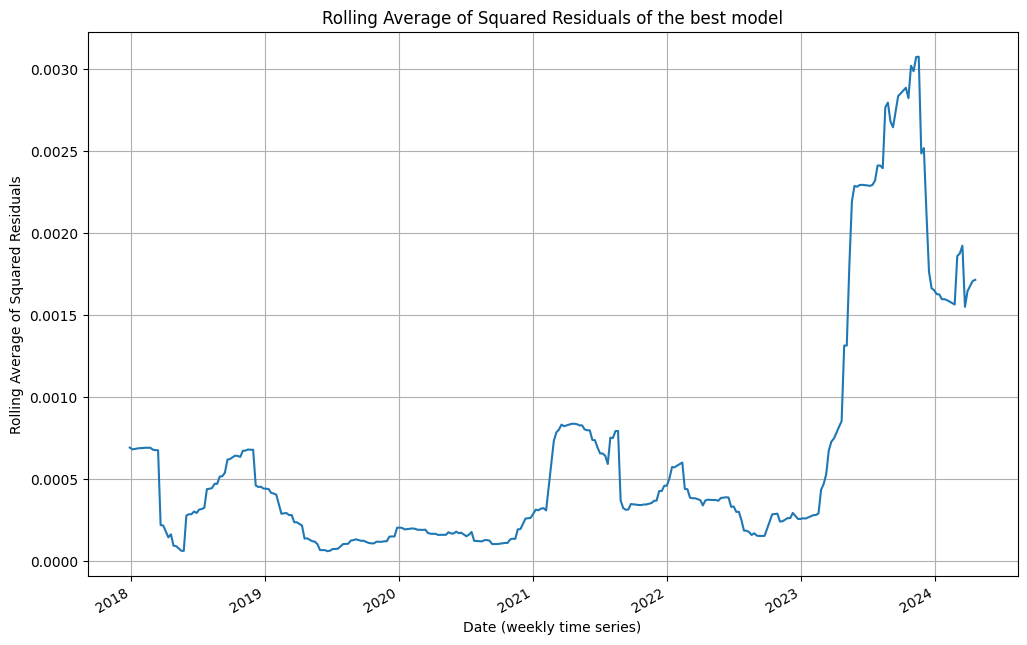

In [ ]:
plot_rolling_average_of_squared_residuals(model_results=fridays_models['AR(2) with Separate Weekly and Monthly Zero Interactions'])

The rolling average follows a totally increasing trend, this indicates a rising volatility, but there also exists a sharp decreasing near the end of year 2023.

# *Robustness work for P11*

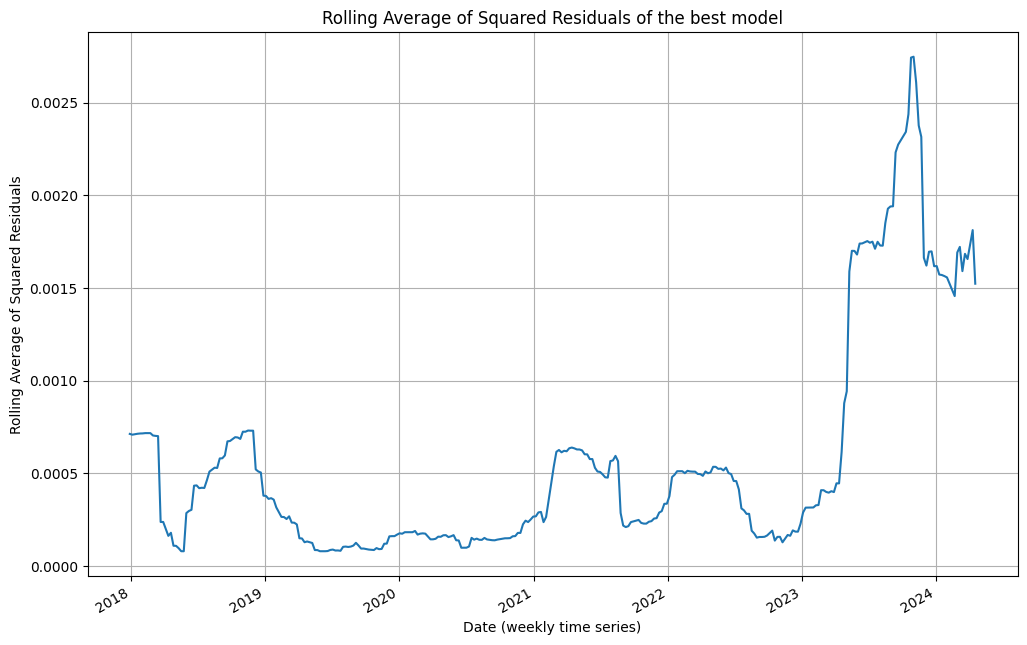

In [ ]:
# Thursdays
plot_rolling_average_of_squared_residuals(model_results=thursdays_models['AR(2) with Separate Weekly and Monthly Zero Interactions'])

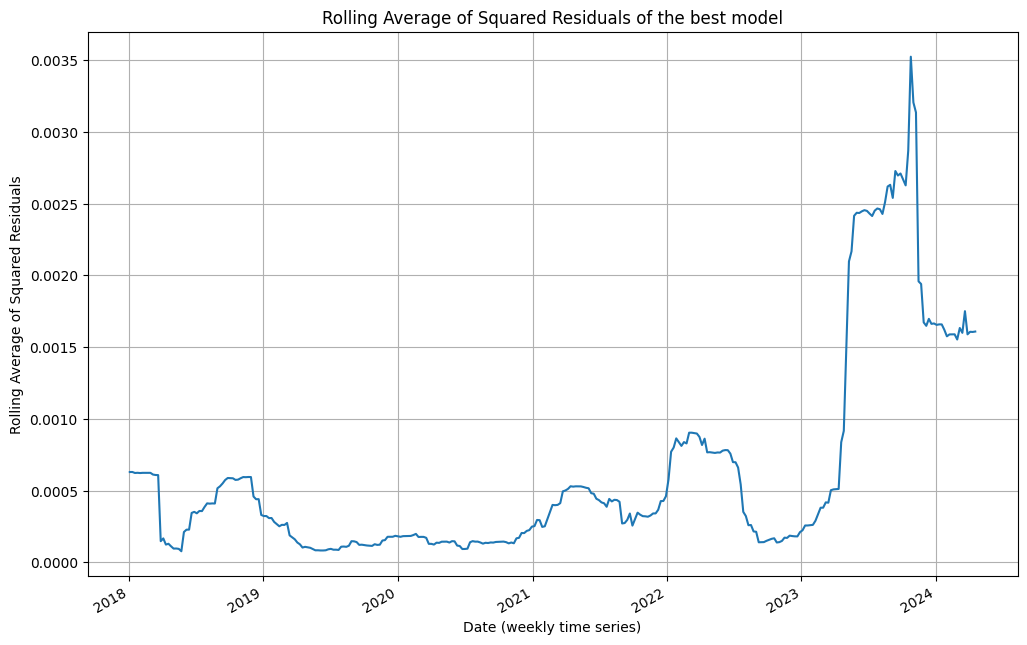

In [ ]:
# Wednesdays
plot_rolling_average_of_squared_residuals(model_results=wednesdays_models['AR(2) with Separate Weekly and Monthly Zero Interactions'])

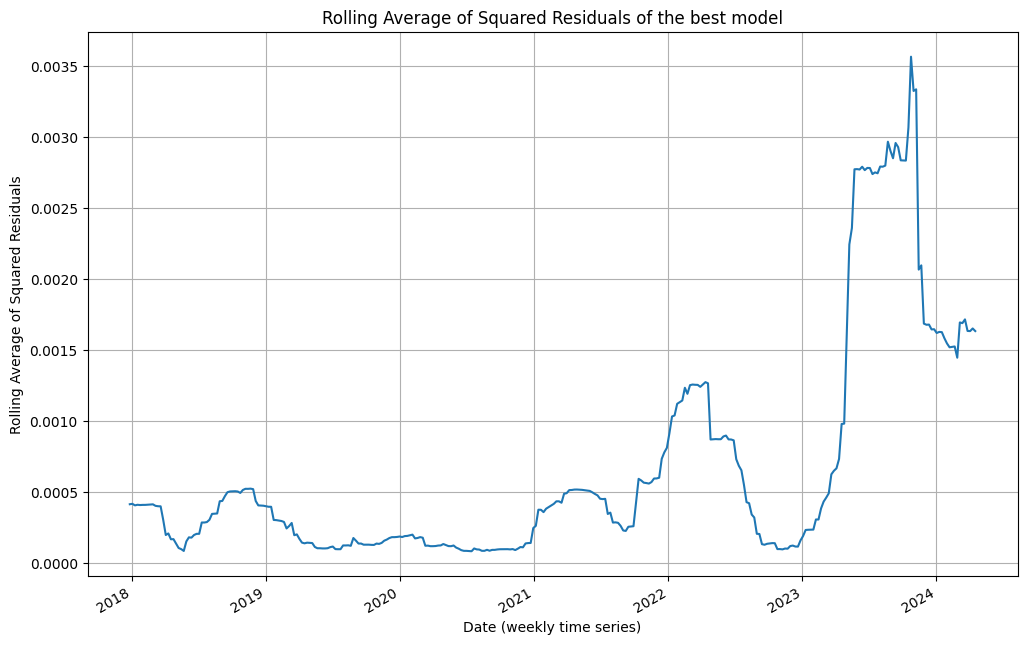

In [ ]:
# Tuesdays
plot_rolling_average_of_squared_residuals(model_results=tuesdays_models['AR(2) with Separate Weekly and Monthly Zero Interactions'])

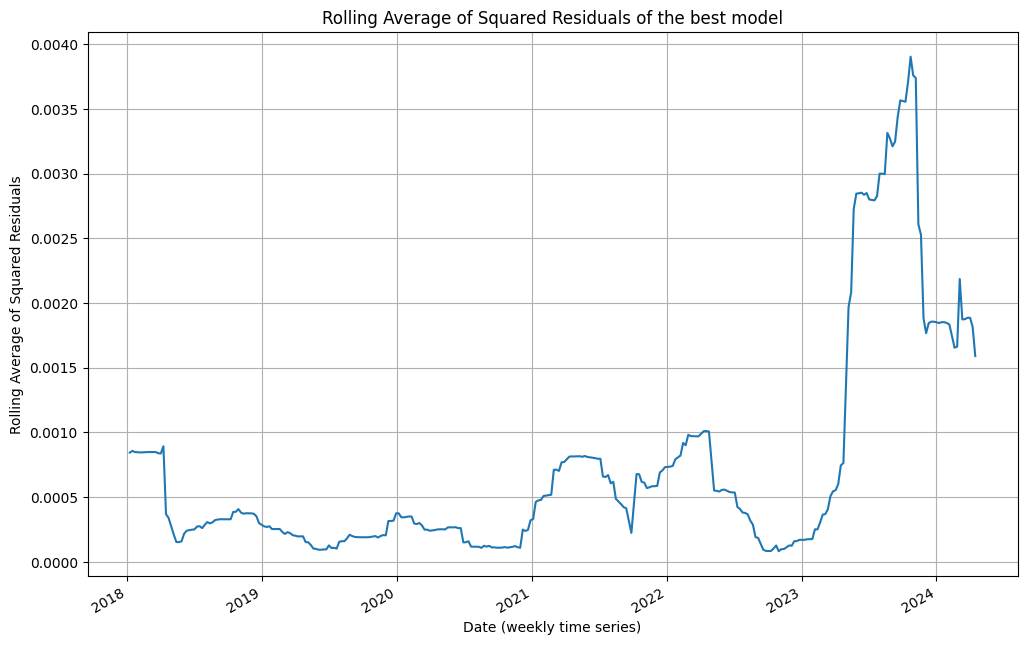

In [ ]:
# Mondays
plot_rolling_average_of_squared_residuals(model_results=mondays_models['AR(2) with Separate Weekly and Monthly Zero Interactions'])

# **New** P12: Perform Out-of-Sample Forecasting and Compute RMSE (Use Fridays as an example)

In [ ]:
def prepare_input_data(df):
    """
    Prepares input data for out-of-sample predictions by creating necessary lagged
    variables and interactions based on the specified models. The function safely
    operates on a copy of the input DataFrame to avoid modifying the original data.

    Parameters:
    - df: Original DataFrame containing the columns ['Log_Return',
        'Zero_Count_22', 'Zero_Count_5', 'Zero_Fraction_5', 'Zero_Fraction_22'].

    Returns:
    - input_data: A new DataFrame with original and derived columns
            necessary for making predictions with all ten models.
    """
    data = df.copy()

    input_data = pd.DataFrame(index=data.index)
    input_data['Log_Return'] = data['Log_Return']
    input_data['Zero_Fraction_5'] = data['Zero_Fraction_5']
    input_data['Zero_Fraction_22'] = data['Zero_Fraction_22']

    # Create lagged features for Log_Return
    input_data['Log_Return_Lag1'] = data['Log_Return'].shift(1)
    input_data['Log_Return_Lag2'] = data['Log_Return'].shift(2)

    # Create interactions for lagged Log_Return with Zero_Fractions
    input_data['Log_Return_Lag1_Zero5'] = input_data['Log_Return_Lag1'] * data['Zero_Fraction_5']
    input_data['Log_Return_Lag1_Zero22'] = input_data['Log_Return_Lag1'] * data['Zero_Fraction_22']
    input_data['Log_Return_Lag2_Zero5'] = input_data['Log_Return_Lag2']  * data['Zero_Fraction_5']
    input_data['Log_Return_Lag2_Zero22'] = input_data['Log_Return_Lag2']  * data['Zero_Fraction_22']

    input_data.dropna(inplace=True)

    # Add constant term for regression
    input_data = sm.add_constant(input_data)

    return input_data

In [ ]:
def calculate_rmse(errors):
    """
    Calculate the root mean squared error for a list of errors.
    """
    mse = np.mean([e**2 for e in errors])
    return np.sqrt(mse)

In [ ]:
def forecast_and_compute_RMSE(df, lags, df_name):
    """
    Performs out-of-sample forecasting using a list of predefined
    models on an expanding window basis. Starting with the first
    52 observations, this function forecasts the 53rd observation
    and continues expanding the sample one observation at a time,
    re-estimating models and forecasting the next observation.
    The forecast errors are calculated for each model and used to
    compute the Root Mean Squared Error (RMSE) for each model's
    predictions. The results are then ranked by RMSE and saved to
    a csv file.

    Parameters:
    - df: A DataFrame containing the time series data, specifically
        a column 'Log_Return' which is used for the forecasting.
    - lags: Maximum number of lags to use for HAC standard errors.
    - df_name: A string that specifies the name of the DataFrame,
          used to name the output CSV file.

    Returns:
    - rmse_df: a DataFrame containing the model names and their
           corresponding RMSE, sorted by RMSE.

    Outputs:
    - Prints a sorted table of the RMSE results for each model.
    - Saves a CSV file named '{df_name}_forecast_rmse_results.csv'
      containing the RMSE results for each model based on input
      dataframe.
    """
    data = df.copy()
    perpared_data = prepare_input_data(data)
    forecast_errors = {name: [] for name, _ in models}

    # Start forecasting from the 53rd observation, using the first 52 observations initially
    for i in range(52, len(perpared_data)):
        current_sample = perpared_data[['Log_Return', 'Zero_Fraction_5',	'Zero_Fraction_22']].iloc[:i]

        for name, model_func in models:

            if name == 'Model with Only Constant':  # Special case for constant model
                forecast = current_sample['Log_Return'].mean()
            else:
                features = model_features[name]
                model = model_func(current_sample, lags)
                input_data = perpared_data.iloc[i][features]
                forecast = model.predict(input_data)

            # Actual return for the next time point (i)
            actual_return = perpared_data['Log_Return'].iloc[i]
            forecast_error = actual_return - forecast
            forecast_errors[name].append(forecast_error)

    # Compute RMSE for each model
    rmses = {name: calculate_rmse(errors) for name, errors in forecast_errors.items()}
    rmse_df = pd.DataFrame(list(rmses.items()), columns=['Model', 'RMSE'])

    # Sort by RMSE
    rmse_df.sort_values(by='RMSE', inplace=True)

    # Print the RMSE table
    print(tabulate(rmse_df, headers='keys', tablefmt='pretty', showindex=False))

    # Save the RMSE results to CSV
    # files.download is just for google colab, if u use other enviroments, plz change
    csv_filename = f'{df_name}_forecast_rmse_results.csv'
    rmse_df.to_csv(csv_filename, index=True, header=True)
    files.download(csv_filename)

    return rmse_df

In [ ]:
fridays_forecast = forecast_and_compute_RMSE(df=Fridays, lags=4, df_name='Fridays')

+----------------------------------------------------------+----------------------+
|                          Model                           |         RMSE         |
+----------------------------------------------------------+----------------------+
| AR(2) with Separate Weekly and Monthly Zero Interactions | 0.028574111727738244 |
|            AR(1) with Weekly Zero Interaction            | 0.028699248262294284 |
|            AR(2) with Weekly Zero Interaction            | 0.028750511204274645 |
|           AR(1) with Monthly Zero Interaction            | 0.033110236042147606 |
|                          AR(2)                           | 0.03319323376216553  |
|                          AR(1)                           | 0.03347683497575105  |
|           AR(2) with Monthly Zero Interaction            |  0.0337186149256691  |
|                 Model with Only Constant                 | 0.047601851591042715 |
|                  Model with Weekly Zero                  | 0.0482323388144

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The model **AR(2) with Separate Weekly and Monthly Zero Interactions** still wins in $RMSE$ criteria. This mix model has the lowest RMSE, which signifies highest accuracy in predictive performance. It means that the mix model's predictions are, on average, closer to the actual observed weekly log return.

**AR(1) with Weekly Zero Interaction** and
**AR(2) with Weekly Zero Interaction** also have very lose $RMSE$
to the mixed model.

# *Robustness work for P12*

In [ ]:
# Thursdays
thursdays_forecast = forecast_and_compute_RMSE(df=Thursdays, lags=2, df_name='Thursdays')

+----------------------------------------------------------+----------------------+
|                          Model                           |         RMSE         |
+----------------------------------------------------------+----------------------+
|            AR(1) with Weekly Zero Interaction            | 0.02644831863828377  |
| AR(2) with Separate Weekly and Monthly Zero Interactions | 0.02645577475084485  |
|            AR(2) with Weekly Zero Interaction            | 0.026687454429006337 |
|           AR(1) with Monthly Zero Interaction            | 0.03100346819508346  |
|                          AR(1)                           | 0.031228836428829586 |
|                          AR(2)                           | 0.03131017690997134  |
|           AR(2) with Monthly Zero Interaction            | 0.03152634740024679  |
|                 Model with Only Constant                 | 0.04684102151231067  |
|                  Model with Weekly Zero                  | 0.0474542805816

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Wednesdays
wednesdays_forecast = forecast_and_compute_RMSE(df=Wednesdays, lags=2, df_name='Wednesdays')

+----------------------------------------------------------+----------------------+
|                          Model                           |         RMSE         |
+----------------------------------------------------------+----------------------+
|            AR(1) with Weekly Zero Interaction            | 0.027619063383236837 |
| AR(2) with Separate Weekly and Monthly Zero Interactions | 0.028173505929623775 |
|            AR(2) with Weekly Zero Interaction            | 0.028430185568081297 |
|                          AR(1)                           |  0.0344754974330957  |
|                          AR(2)                           | 0.034532832194297196 |
|           AR(1) with Monthly Zero Interaction            | 0.03482136156950505  |
|           AR(2) with Monthly Zero Interaction            | 0.03567962652680273  |
|                 Model with Only Constant                 | 0.047647999920785465 |
|                 Model with Monthly Zero                  | 0.0481491645707

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Tuesdays
tuesdays_forecast = forecast_and_compute_RMSE(df=Tuesdays, lags=2, df_name='Tuesdays')

+----------------------------------------------------------+----------------------+
|                          Model                           |         RMSE         |
+----------------------------------------------------------+----------------------+
| AR(2) with Separate Weekly and Monthly Zero Interactions | 0.029554669343551537 |
|            AR(2) with Weekly Zero Interaction            | 0.029972662026528443 |
|            AR(1) with Weekly Zero Interaction            | 0.030109608823150988 |
|                          AR(2)                           |  0.0363193179205231  |
|                          AR(1)                           | 0.03668898286049331  |
|           AR(1) with Monthly Zero Interaction            | 0.03711598115118176  |
|           AR(2) with Monthly Zero Interaction            |  0.0373343424740437  |
|                 Model with Only Constant                 | 0.048320938820529416 |
|                  Model with Weekly Zero                  | 0.0489265347157

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Mondays
mondays_forecast = forecast_and_compute_RMSE(df=Mondays, lags=2, df_name='Mondays')

+----------------------------------------------------------+----------------------+
|                          Model                           |         RMSE         |
+----------------------------------------------------------+----------------------+
| AR(2) with Separate Weekly and Monthly Zero Interactions | 0.031247302347774532 |
|            AR(1) with Weekly Zero Interaction            | 0.03165887030234597  |
|            AR(2) with Weekly Zero Interaction            | 0.03215754992225925  |
|                          AR(2)                           | 0.03668184362733399  |
|           AR(1) with Monthly Zero Interaction            |  0.0368788773003294  |
|                          AR(1)                           | 0.037050763630292645 |
|           AR(2) with Monthly Zero Interaction            | 0.037297806583013175 |
|                 Model with Only Constant                 | 0.04851899399219849  |
|                  Model with Weekly Zero                  |  0.049180601706

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The mix model **AR(2) with Separate Weekly and Monthly Zero Interactions**
has second lowest $RMSE$ for Thursdays dataframe and Wednesdays dataframe.

The mix model has first lowest $RMSE$ for Fridays, Tuesdays, Mondays dataframe.

# Source of the weirdly lowh Ljung Box p-values for the Fridays series

In [ ]:
model_test = fridays_models['AR(2) with Separate Weekly and Monthly Zero Interactions']
residuals = model_test.resid
ljung_box_results = acorr_ljungbox(residuals, lags=[3], return_df=True)

print("Ljung-Box test results for the first three lags:")
print(ljung_box_results)

Ljung-Box test results for the first three lags:
     lb_stat  lb_pvalue
3  22.284808   0.000057


large 'lb_stat' and low 'lb_pvalue'

### Compute the autocorrelations of the residuals at the first three lags

In [ ]:
# Fridays
model_test = fridays_models['AR(2) with Separate Weekly and Monthly Zero Interactions']
residuals = model_test.resid
autocorrs = acf(residuals, nlags=3, fft=True)
print("Autocorrelations at the first three lags:", autocorrs[1:])
print("Fridays' third autocorrelation:", autocorrs[3])

Autocorrelations at the first three lags: [ 0.02258348 -0.03011749  0.25872257]
Fridays' third autocorrelation: 0.25872257471076554


In [58]:
# Mondays
model_test = mondays_models['AR(2) with Separate Weekly and Monthly Zero Interactions']
residuals = model_test.resid
autocorrs = acf(residuals, nlags=3, fft=True)
print("Autocorrelations at the first three lags:", autocorrs[1:])
print("Mondays' third autocorrelation:", autocorrs[3])

Autocorrelations at the first three lags: [0.01126529 0.02770651 0.11017399]
Mondays' third autocorrelation: 0.11017399321047239


In [ ]:
# Tuesdays
model_test = tuesdays_models['AR(2) with Separate Weekly and Monthly Zero Interactions']
residuals = model_test.resid
autocorrs = acf(residuals, nlags=3, fft=True)
print("Autocorrelations at the first three lags:", autocorrs[1:])
print("Tuesdays' third autocorrelation:", autocorrs[3])

Autocorrelations at the first three lags: [-0.00606683  0.06982995  0.05248715]
Tuesdays' third autocorrelation: 0.05248715210374084


In [59]:
# Wednesdays
model_test = wednesdays_models['AR(2) with Separate Weekly and Monthly Zero Interactions']
residuals = model_test.resid
autocorrs = acf(residuals, nlags=3, fft=True)
print("Autocorrelations at the first three lags:", autocorrs[1:])
print("Wednesdays' third autocorrelation:", autocorrs[3])

Autocorrelations at the first three lags: [0.06856758 0.02536327 0.02979565]
Wednesdays' third autocorrelation: 0.029795653661547118


In [60]:
# Thursdays
model_test = thursdays_models['AR(2) with Separate Weekly and Monthly Zero Interactions']
residuals = model_test.resid
autocorrs = acf(residuals, nlags=3, fft=True)
print("Autocorrelations at the first three lags:", autocorrs[1:])
print("Thursdays' third autocorrelation:", autocorrs[3])

Autocorrelations at the first three lags: [ 0.05798363 -0.02744602  0.08398479]
Thursdays' third autocorrelation: 0.08398478977334237


Comparing Fridays and other four data, it is obivous that the reason for the Ljung-Box test rejecting the null hypothesis of no autocorrelation for models based on Fridays is the unusually higher third autocorrelation ($0.258$)
than other four data ($0.11, 0.052, 0.03, 0.084$), where first two autocorrelations have no significant difference between these five data.